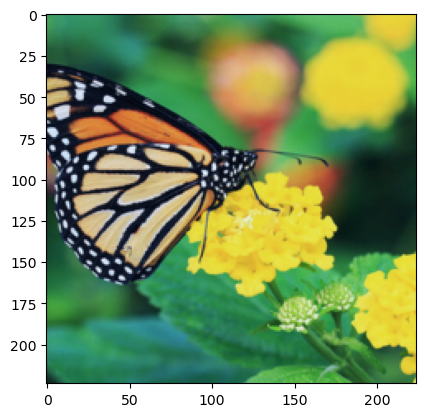

In [18]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def vis_image(img):
    img = torch.permute(img, (1, 2, 0))
    return (img - img.min()) / (img.max() - img.min())

def get_data(path):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])
    img = Image.open(path)
    out = transform(img)
    return out

path = 'sample_images/butterfly.JPEG'
img = get_data(path)
plt.imshow(vis_image(img))
plt.show()

In [10]:
from torchvision import models
net = models.vgg19(weights="DEFAULT")

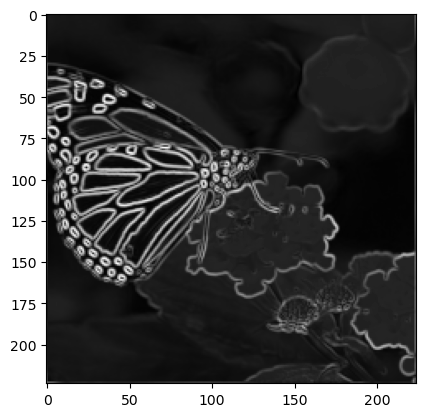

In [20]:
import torch.nn as nn
from torch.nn.functional import pad
from torch.linalg import norm

def patchify(x, patch_size, stride_size, padding=None, pad_type='zeros'):
    q1, q2 = patch_size
    s1, s2 = stride_size

    if padding is None:
        pad_1 = (q1-1)//2
        pad_2 = (q2-1)//2
    else:
        pad_1, pad_2 = padding

    pad_dims = (pad_2, pad_2, pad_1, pad_1)
    if pad_type == 'zeros':
        x = pad(x, pad_dims)
    elif pad_type == 'circular':
        x = pad(x, pad_dims, 'circular')

    patches = x.unfold(2, q1, s1).unfold(3, q2, s2)
    patches = patches.transpose(1, 3).transpose(1, 2)
    return patches

def transform_image(net, img, layer_idx=0):

    count = -1
    for idx, p in enumerate(net.parameters()):
        if len(p.shape) > 1:
            count += 1
        if count == layer_idx:
            M = p.data
            _, ki, q, s = M.shape

            M = M.reshape(-1, ki*q*s)
            M = torch.einsum('nd, nD -> dD', M, M)
            break
            
    count = 0    
    l_idx = None
    for idx, m in enumerate(net.features):
        if isinstance(m, nn.Conv2d):
            count += 1

        if count-1 == layer_idx:
            l_idx = idx
            break     
            
    net.eval()
    img = net.features[:l_idx](img)    
    
    patches = patchify(img, (q, s), (1, 1))

    n, w, h, q, s, c = patches.shape
    patches = patches.reshape(n, w, h, q*s*c)
    M_patch = torch.einsum('nwhd, dD -> nwhD', patches, M)
    M_patch = norm(M_patch, dim=-1)    
    return M_patch.data.cpu()


transformed_img = transform_image(net, img.unsqueeze(0), layer_idx=0)
plt.imshow(vis_image(transformed_img), cmap='gray')
plt.show()
